<a href="https://colab.research.google.com/github/Fibonacci1664/Pix2Pix/blob/main/MyPix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/

https://www.tensorflow.org/tutorials/generative/pix2pix

# **IMPORTS**

In [82]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2DTranspose
from keras.layers import Dropout

import numpy as np

print(tf.__version__)

2.9.2


# **LOAD DATA**

(256, 512, 3)


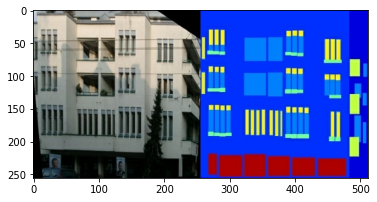

In [83]:
dataset_name = "facades"

_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

list(PATH.parent.iterdir())

# Each original image is of size 256 x 512, which in and of itself contains two 256 x 256 images
# Print out a smaple image to ensure the dataset has loaded correctly
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

plt.figure()
plt.imshow(sample_image)

# **PREPROCESS DATA**

### **SPLIT IMAGES INTO TWO SEPARATE IMAGES, REAL/LABEL or TARGET/INPUT**

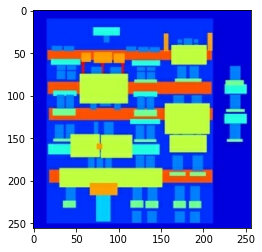

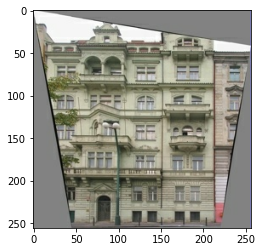

In [84]:
# To separate real building facade images from the architecture label images — all of which will be of size 256 x 256.
# Define a function that loads image files and outputs two image tensors, these two images will be the 256 x 512 separated

def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image 
    w = tf.shape(image)[1]                # 512
    w = w // 2                            # 256
    input_image = image[:, w:, :]         # From 256 - end
    real_image = image[:, :w, :]          # From start - 256

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

# Plot a sample of the input (architecture label image) and real (building facade photo) images
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

### **HELPER FUNCTIONS TO AUGMENT DATA**

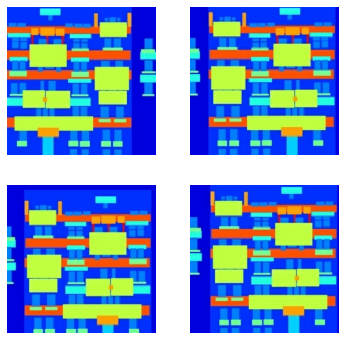

In [85]:
# As described in the pix2pix paper, you need to apply random jittering and mirroring to preprocess the training set.

# Define several functions that:

# Resize each 256 x 256 image to a larger height and width—286 x 286.
# Randomly crop it back to 256 x 256.
# Randomly flip the image horizontally i.e. left to right (random mirroring).
# Normalize the images to the [-1, 1] range.

# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

# Inspect some of the preprocessed output
plt.figure(figsize=(6, 6))

for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')

plt.show()

### **HELPER FUNCTIONS THAT LOAD AND PREPROCESS THE TRAIN/TEST SETS**

In [86]:
# Helper functions that load and preprocess the training and test sets
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                    IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

# **BUILD INPUT PIPELINE**

In [87]:
# Build an input pipeline with tf.data
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

try:
    test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))

test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# **HELPER FUNCTION TO CALCULATE THE RECEPTIVE FIELD**

In [88]:
# example of calculating the receptive field for the PatchGAN
# The receptive field is the relationship between one output activation of the model to an area on the input image

# calculate the effective receptive field size
def receptive_field(output_size, kernel_size, stride_size):
    return (output_size - 1) * stride_size + kernel_size

# output layer 1x1 pixel with 4x4 kernel and 1x1 stride
rf = receptive_field(1, 4, 1)
print(rf)
# second last layer with 4x4 kernel and 1x1 stride
rf = receptive_field(rf, 4, 1)
print(rf)
# 3 PatchGAN layers with 4x4 kernel and 2x2 stride
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)
rf = receptive_field(rf, 4, 2)
print(rf)

4
7
16
34
70


# **U-NET GENERATOR MODEL**

In [89]:
OUTPUT_CHANNELS = 3

### **HELPER FUNCTION TO DEFINE AN ENCODER BLOCK**

In [90]:
# define an encoder block, we could add drop out during the downsampling as well, what effect does that have??
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization / or he_normal?
	#init = RandomNormal(stddev=0.02)
	init = tf.random_normal_initializer(0., 0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

### **HELPER FUNCTION TO DEFINE AN DECODER BLOCK**

In [91]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	#init = RandomNormal(stddev=0.02)
	init = tf.random_normal_initializer(0., 0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

### **GENERATOR MODEL - U-NET**

The generator model for Pix2Pix is implemented as a U-Net.

[Insert own diagram of U-Net with dims included]

Encoder: C64-C128-C256-C512-C512-C512-C512-C512

Decoder: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_164 (Conv2D)            (None, 128, 128, 64  3072        ['input_34[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_142 (LeakyReLU)    (None, 128, 128, 64  0           ['conv2d_164[0][0]']             
                                )                                                          

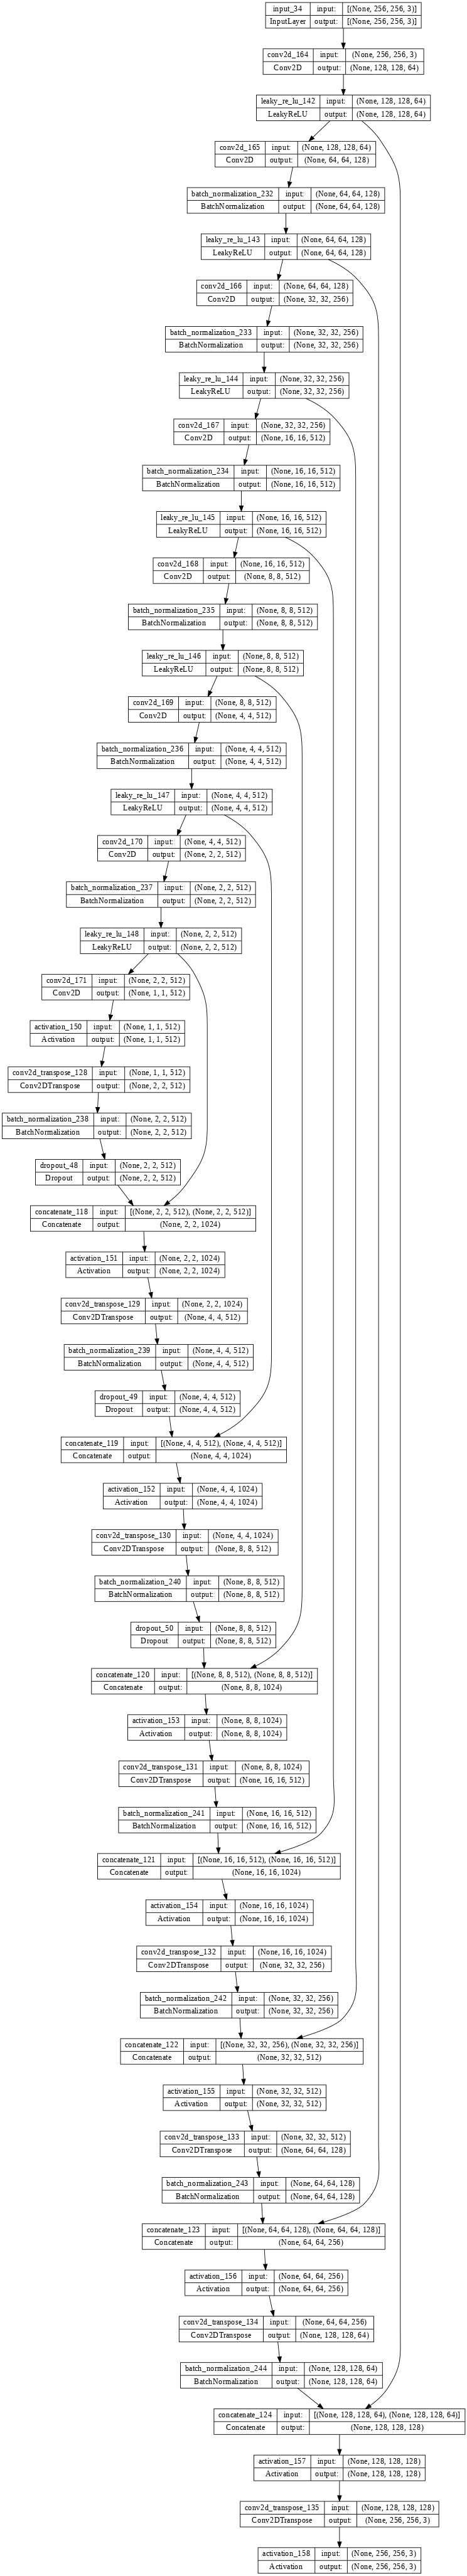

In [92]:
# example of defining a u-net encoder-decoder generator model

# define the standalone generator model
# image_shape=(256,256,3) // That was parameters inside the function parenthesis
def define_generator(image_shape=(256,256,3)):

	#inputs = tf.keras.layers.Input(shape=[256, 256, 3])
	# weight initialization
	#init = RandomNormal(stddev=0.02)
	init = tf.random_normal_initializer(0., 0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(OUTPUT_CHANNELS, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define image shape
image_shape = (256,256,3)
# create the model
gen_model = define_generator()
# summarize the model
gen_model.summary()
# plot the model
plot_model(gen_model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True, dpi=64)

# **TEST THE GENERATOR**

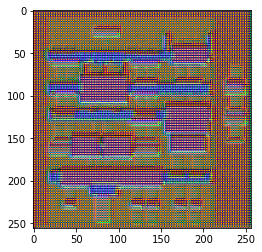

In [103]:
# TEST THE GENERATOR
gen_model_output = gen_model(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_model_output[0, ...])

# **DEFINE GENERATOR LOSS**

In [94]:
# GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the pix2pix paper.

# The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
# The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
# This allows the generated image to become structurally similar to the target image.
# The formula to calculate the total generator loss is gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

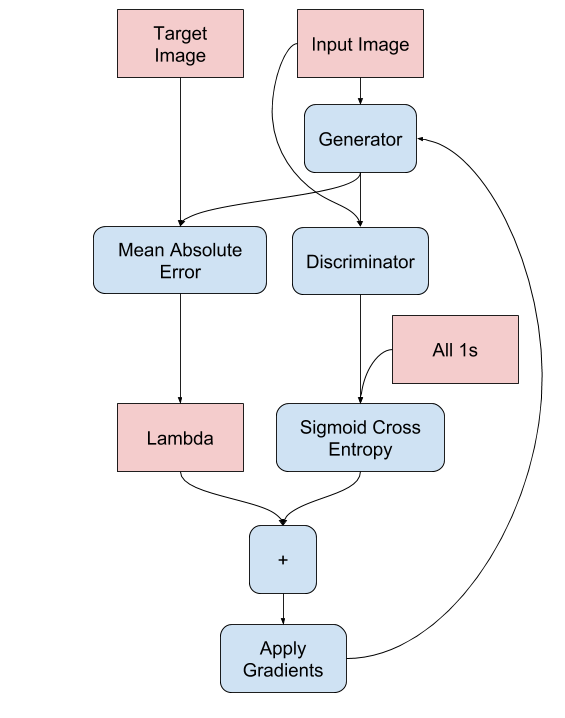

# **PATCH GAN DISCRIMINATOR MODEL**

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_52 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_53 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_133 (Concatenate)  (None, 256, 256, 6)  0           ['input_52[0][0]',               
                                                                  'input_53[0][0]']        

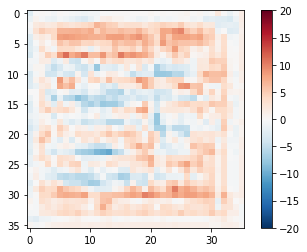

In [104]:
# example of defining a 70x70 patchgan discriminator model
# functional API

# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
	#init = RandomNormal(stddev=0.02)
	init = tf.random_normal_initializer(0., 0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init, use_bias=False)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	zero_pad1 = tf.keras.layers.ZeroPadding2D()(d)

	# C512
	d = Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init, use_bias=False)(zero_pad1)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	zero_pad2 = tf.keras.layers.ZeroPadding2D()(d)
  
	# second last output layer
	# d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	# d = BatchNormalization()(d)
	# d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), strides=1, padding='same', kernel_initializer=init)(zero_pad2)
	#patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], d)
	# compile model
	# opt = Adam(learning_rate=0.0002, beta_1=0.5)
	# model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define image shape
image_shape = (256,256,3)
# create the model
disc_model = define_discriminator(image_shape)
# summarize the model
disc_model.summary()
# plot the model
plot_model(disc_model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True, dpi=64)



# TEST THE DISCRIMINATOR
disc_output = disc_model([inp[tf.newaxis, ...], gen_model_output], training=False)
plt.imshow(disc_output[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

# **DEFINE GAN**

In [51]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# **DEFINE COMPOSITE MODEL**

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_14 (Functional)          (None, 256, 256, 3)  54424323    ['input_26[0][0]']               
                                                                                                  
 model_15 (Functional)          (None, 16, 16, 1)    6968257     ['input_26[0][0]',               
                                                                  'model_14[0][0]']               
                                                                                           

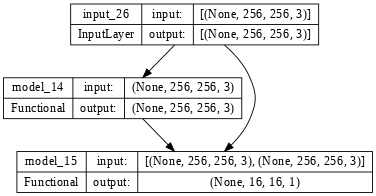

In [52]:
# define image shape
image_shape = (256,256,3)
# define the models
g_model = define_generator(image_shape)
d_model = define_discriminator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True, dpi=64)